# SKU-110K: Dataset Analysis

### 1. Initial Setup

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import storage
import io
from PIL import Image
import random
from tqdm.notebook import tqdm

### 2. Configure Project and Storage Client

In [2]:
# Set up GCP project
PROJECT_ID = 'shelfscout'
BUCKET_NAME = 'sku-110k-dataset'

# Initialize storage client
storage_client = storage.Client(project=PROJECT_ID)
bucket = storage_client.get_bucket(BUCKET_NAME)

### 3. DATASET DISTRIBUTION ANALYSIS

Dataset Distribution:
Train: 8185 images (70.0%)
Validation: 584 images (5.0%)
Test: 2920 images (25.0%)
Total: 11689 images


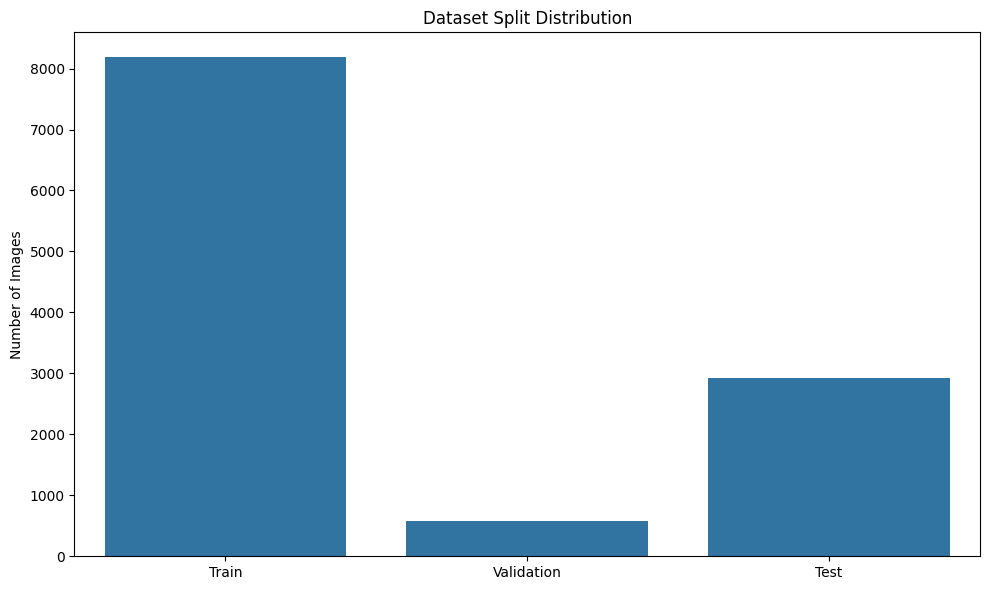

In [3]:
# Function to count files in a GCS path
def count_files(prefix):
    blobs = list(bucket.list_blobs(prefix=prefix))
    return len([blob for blob in blobs if not blob.name.endswith('/')])

# Define dataset paths and count images
train_path = 'SKU110K_Kaggle/images/train/'
val_path = 'SKU110K_Kaggle/images/val/'
test_path = 'SKU110K_Kaggle/images/test/'

train_count = count_files(train_path)
val_count = count_files(val_path)
test_count = count_files(test_path)

# Calculate total and percentages
total_images = train_count + val_count + test_count
train_percent = (train_count / total_images) * 100
val_percent = (val_count / total_images) * 100
test_percent = (test_count / total_images) * 100

# Display split distribution
print("Dataset Distribution:")
print(f"Train: {train_count} images ({train_percent:.1f}%)")
print(f"Validation: {val_count} images ({val_percent:.1f}%)")
print(f"Test: {test_count} images ({test_percent:.1f}%)")
print(f"Total: {total_images} images")

# Visualize split distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=['Train', 'Validation', 'Test'], 
            y=[train_count, val_count, test_count])
plt.title('Dataset Split Distribution')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()

### 4. IMAGE PROPERTIES ANALYSIS

Analyzing image properties (this may take a minute)...


Analyzing SKU110K_Kaggle/images/train/:   0%|          | 0/50 [00:00<?, ?it/s]

Analyzing SKU110K_Kaggle/images/val/:   0%|          | 0/25 [00:00<?, ?it/s]

Analyzing SKU110K_Kaggle/images/test/:   0%|          | 0/50 [00:00<?, ?it/s]


Image Property Statistics:
Resolution: 2402.4×3200.0 pixels (mean)
Width range: 1920-4160 pixels
Height range: 1920-5312 pixels
Aspect ratio: 0.78 (mean), 0.56-1.78 (range)


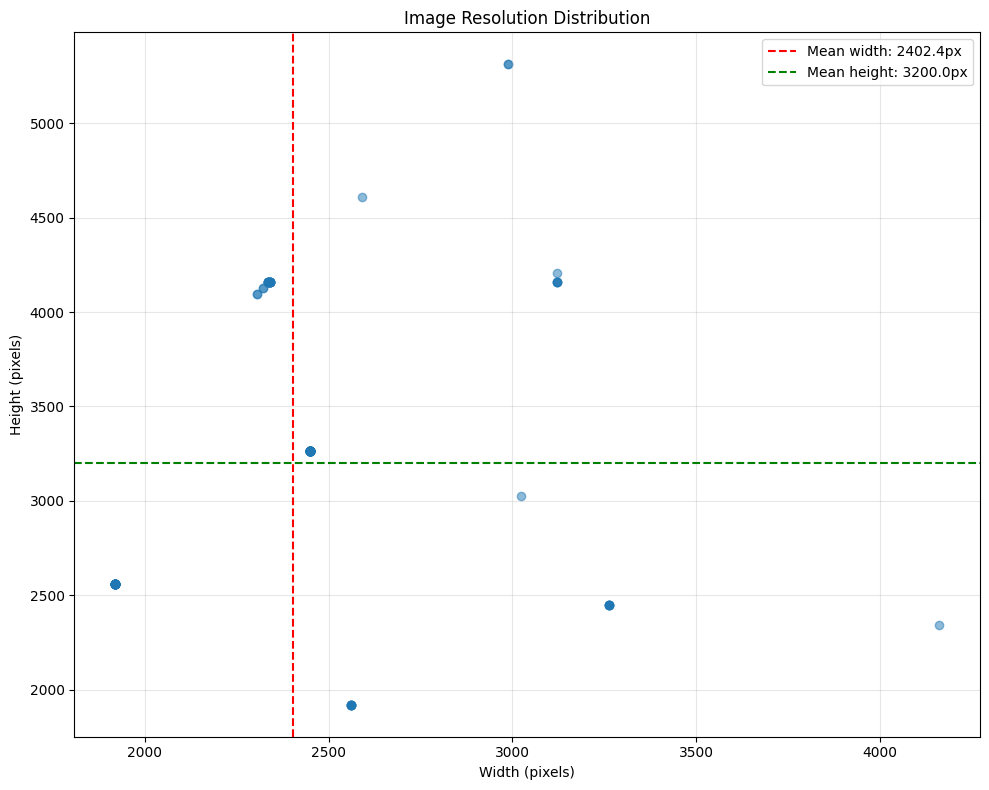

In [4]:
# Sample random images from each split for analysis
def analyze_image_sample(prefix, sample_size=50):
    """Analyze properties of a random sample of images"""
    # List all images
    blobs = list(bucket.list_blobs(prefix=prefix))
    image_blobs = [blob for blob in blobs if not blob.name.endswith('/') 
                  and blob.name.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    # Sample images
    if len(image_blobs) > sample_size:
        sampled_blobs = random.sample(image_blobs, sample_size)
    else:
        sampled_blobs = image_blobs
    
    # Properties to collect
    widths, heights, aspects = [], [], []
    
    # Analyze each image
    for blob in tqdm(sampled_blobs, desc=f"Analyzing {prefix}"):
        image_data = blob.download_as_bytes()
        img = Image.open(io.BytesIO(image_data))
        width, height = img.size
        aspect = width / height
        
        widths.append(width)
        heights.append(height)
        aspects.append(aspect)
    
    return {'widths': widths, 'heights': heights, 'aspects': aspects}

# Sample from each split and combine (smaller samples for efficiency)
print("Analyzing image properties (this may take a minute)...")
train_props = analyze_image_sample(train_path, sample_size=50)
val_props = analyze_image_sample(val_path, sample_size=25)
test_props = analyze_image_sample(test_path, sample_size=50)

# Combine properties
widths = train_props['widths'] + val_props['widths'] + test_props['widths']
heights = train_props['heights'] + val_props['heights'] + test_props['heights']
aspects = train_props['aspects'] + val_props['aspects'] + test_props['aspects']

# Calculate key statistics
width_mean, width_std = np.mean(widths), np.std(widths)
height_mean, height_std = np.mean(heights), np.std(heights)
aspect_mean, aspect_std = np.mean(aspects), np.std(aspects)

# Display key image statistics
print("\nImage Property Statistics:")
print(f"Resolution: {width_mean:.1f}×{height_mean:.1f} pixels (mean)")
print(f"Width range: {min(widths)}-{max(widths)} pixels")
print(f"Height range: {min(heights)}-{max(heights)} pixels")
print(f"Aspect ratio: {aspect_mean:.2f} (mean), {min(aspects):.2f}-{max(aspects):.2f} (range)")

# Resolution visualization
plt.figure(figsize=(10, 8))
plt.scatter(widths, heights, alpha=0.5)
plt.axvline(width_mean, color='r', linestyle='--', label=f'Mean width: {width_mean:.1f}px')
plt.axhline(height_mean, color='g', linestyle='--', label=f'Mean height: {height_mean:.1f}px')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.title('Image Resolution Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 5. ANNOTATION ANALYSIS


Analyzing annotations...


Analyzing SKU110K_Kaggle/labels/train/:   0%|          | 0/50 [00:00<?, ?it/s]

Analyzing SKU110K_Kaggle/labels/val/:   0%|          | 0/25 [00:00<?, ?it/s]

Analyzing SKU110K_Kaggle/labels/test/:   0%|          | 0/50 [00:00<?, ?it/s]


Annotation Statistics:
Objects per image: 144.0 (mean), 138.0 (median)
Object count range: 34-410 objects per image
Average bounding box area: 0.024052 (normalized)
Total objects analyzed: 18006


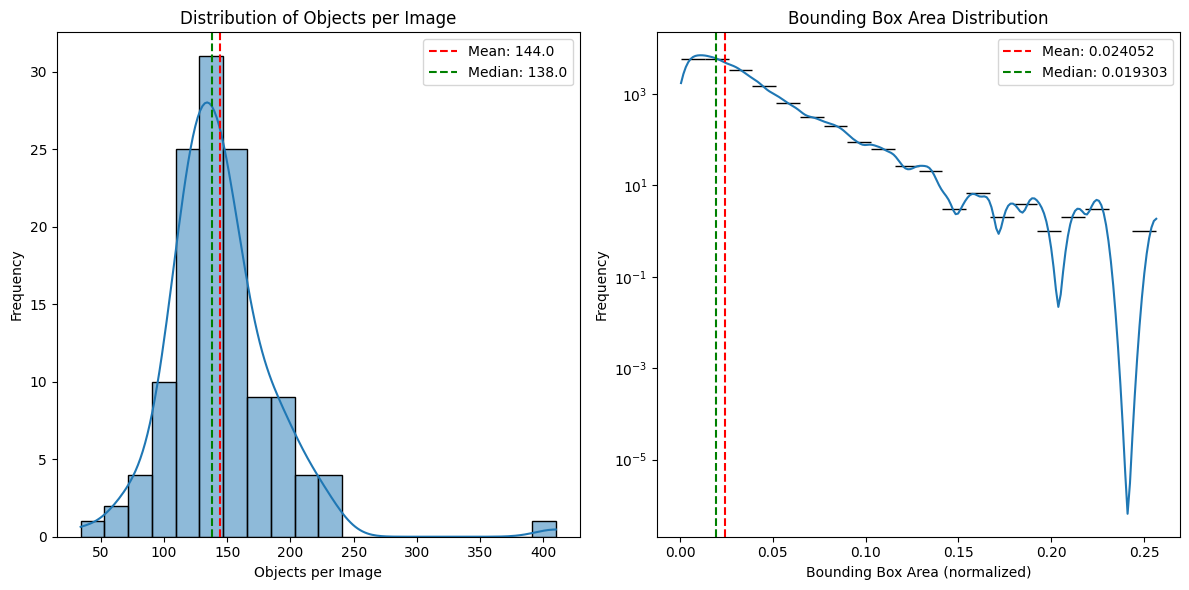

In [5]:
def analyze_annotations_sample(labels_path, sample_size=50):
    """Analyze annotations for a sample of images"""
    # List all annotation files
    blobs = list(bucket.list_blobs(prefix=labels_path))
    label_blobs = [blob for blob in blobs if not blob.name.endswith('/')]
    
    # Sample annotations
    if len(label_blobs) > sample_size:
        sampled_blobs = random.sample(label_blobs, sample_size)
    else:
        sampled_blobs = label_blobs
    
    # Stats to collect
    objects_per_image = []
    bbox_areas = []
    
    # Analyze each annotation file
    for blob in tqdm(sampled_blobs, desc=f"Analyzing {labels_path}"):
        content = blob.download_as_text()
        lines = content.strip().split('\n')
        
        # Count objects
        num_objects = len(lines)
        objects_per_image.append(num_objects)
        
        # Process each bounding box
        for line in lines:
            try:
                parts = line.strip().split()
                # SKU-110K format is typically: x1 y1 width height confidence
                x1, y1, width, height = map(float, parts[:4])
                
                # Calculate area (normalized)
                area = width * height
                bbox_areas.append(area)
                
            except Exception as e:
                print(f"Error parsing line: {line}, {e}")
                continue
    
    return {
        'objects_per_image': objects_per_image,
        'bbox_areas': bbox_areas
    }

# Analyze annotations from each split
print("\nAnalyzing annotations...")
train_annot = analyze_annotations_sample('SKU110K_Kaggle/labels/train/', sample_size=50)
val_annot = analyze_annotations_sample('SKU110K_Kaggle/labels/val/', sample_size=25)
test_annot = analyze_annotations_sample('SKU110K_Kaggle/labels/test/', sample_size=50)

# Combine results
all_objects_per_image = train_annot['objects_per_image'] + val_annot['objects_per_image'] + test_annot['objects_per_image']
all_bbox_areas = train_annot['bbox_areas'] + val_annot['bbox_areas'] + test_annot['bbox_areas']

# Calculate key statistics
obj_mean = np.mean(all_objects_per_image)
obj_median = np.median(all_objects_per_image)
obj_min, obj_max = min(all_objects_per_image), max(all_objects_per_image)

area_mean = np.mean(all_bbox_areas)
area_median = np.median(all_bbox_areas)

# Display key annotation statistics
print("\nAnnotation Statistics:")
print(f"Objects per image: {obj_mean:.1f} (mean), {obj_median:.1f} (median)")
print(f"Object count range: {obj_min}-{obj_max} objects per image")
print(f"Average bounding box area: {area_mean:.6f} (normalized)")
print(f"Total objects analyzed: {len(all_bbox_areas)}")

# Visualize objects per image distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(all_objects_per_image, bins=20, kde=True)
plt.axvline(obj_mean, color='r', linestyle='--', label=f'Mean: {obj_mean:.1f}')
plt.axvline(obj_median, color='g', linestyle='--', label=f'Median: {obj_median:.1f}')
plt.xlabel('Objects per Image')
plt.ylabel('Frequency')
plt.title('Distribution of Objects per Image')
plt.legend()

# Visualize bounding box area distribution
plt.subplot(1, 2, 2)
sns.histplot(all_bbox_areas, bins=20, kde=True, log_scale=(False, True))
plt.axvline(area_mean, color='r', linestyle='--', label=f'Mean: {area_mean:.6f}')
plt.axvline(area_median, color='g', linestyle='--', label=f'Median: {area_median:.6f}')
plt.xlabel('Bounding Box Area (normalized)')
plt.ylabel('Frequency')
plt.title('Bounding Box Area Distribution')
plt.legend()

plt.tight_layout()
plt.show()

### 6. SUMMARY REPORT

In [6]:
# Create a comprehensive summary for model development
summary = pd.DataFrame({
    'Metric': [
        'Total Images',
        'Training Split',
        'Validation Split',
        'Test Split',
        'Mean Image Resolution',
        'Resolution Range',
        'Mean Aspect Ratio',
        'Mean Objects per Image',
        'Objects per Image Range',
        'Mean Bounding Box Area',
        'Model Target Resolution',
        'Required Preprocessing'
    ],
    'Value': [
        f"{total_images}",
        f"{train_count} images ({train_percent:.1f}%)",
        f"{val_count} images ({val_percent:.1f}%)",
        f"{test_count} images ({test_percent:.1f}%)",
        f"{width_mean:.1f}×{height_mean:.1f} pixels",
        f"{min(widths)}×{min(heights)} to {max(widths)}×{max(heights)} pixels",
        f"{aspect_mean:.2f} (range: {min(aspects):.2f}-{max(aspects):.2f})",
        f"{obj_mean:.1f} (median: {obj_median:.1f})",
        f"{obj_min}-{obj_max} objects",
        f"{area_mean:.6f} (normalized)",
        "640×640 pixels (recommended)",
        "Resize maintaining aspect ratio + normalization"
    ]
})

# Display summary
print("\nSKU-110K Dataset Analysis Summary:")
print("="*50)
print(summary.to_string(index=False))
print("="*50)


SKU-110K Dataset Analysis Summary:
                 Metric                                           Value
           Total Images                                           11689
         Training Split                             8185 images (70.0%)
       Validation Split                               584 images (5.0%)
             Test Split                             2920 images (25.0%)
  Mean Image Resolution                            2402.4×3200.0 pixels
       Resolution Range                   1920×1920 to 4160×5312 pixels
      Mean Aspect Ratio                         0.78 (range: 0.56-1.78)
 Mean Objects per Image                           144.0 (median: 138.0)
Objects per Image Range                                  34-410 objects
 Mean Bounding Box Area                           0.024052 (normalized)
Model Target Resolution                    640×640 pixels (recommended)
 Required Preprocessing Resize maintaining aspect ratio + normalization


### 7. MODEL DEVELOPMENT INSIGHTS

In [7]:
print("\nKey Insights for Model Development:")
print("1. High object density (avg. %d objects per image) suggests:" % obj_mean)
print("   - Need for high-resolution input to distinguish small objects")
print("   - Model architecture with strong small-object detection capability")
print("   - Potential for anchor optimization for small, densely packed objects")

print("\n2. Resolution considerations:")
print("   - Significant variation in image sizes requires consistent resizing")
print("   - Recommend 640×640 target size (standard for object detection)")
print("   - Must preserve aspect ratio during resizing to avoid distortion")

print("\n3. Data distribution:")
print("   - Strong train/val/test split already provided (70/5/25)")
print("   - No need for additional splitting")
print("   - Sufficient training data (%d images)" % train_count)

print("\n4. Preprocessing requirements:")
print("   - Resize images to 640×640 while maintaining aspect ratio")
print("   - Apply padding where necessary")
print("   - Normalize pixel values to [0-1] range")
print("   - Convert to TFRecord format for efficient training")

# Save this report
summary.to_csv('sku110k_dataset_summary.csv', index=False)
print("\nSummary saved to 'sku110k_dataset_summary.csv'")



Key Insights for Model Development:
1. High object density (avg. 144 objects per image) suggests:
   - Need for high-resolution input to distinguish small objects
   - Model architecture with strong small-object detection capability
   - Potential for anchor optimization for small, densely packed objects

2. Resolution considerations:
   - Significant variation in image sizes requires consistent resizing
   - Recommend 640×640 target size (standard for object detection)
   - Must preserve aspect ratio during resizing to avoid distortion

3. Data distribution:
   - Strong train/val/test split already provided (70/5/25)
   - No need for additional splitting
   - Sufficient training data (8185 images)

4. Preprocessing requirements:
   - Resize images to 640×640 while maintaining aspect ratio
   - Apply padding where necessary
   - Normalize pixel values to [0-1] range
   - Convert to TFRecord format for efficient training

Summary saved to 'sku110k_dataset_summary.csv'
